# Big Data

## Dask
* A [package](https://dask.org/) which facilitates chunking of data to fit in memory and parallelism to your code
* Setup is as simple as enable it and forget
* It integrates with popular packages like Numpy, Pandas and Xarray, so no additional syntaxes to learn.
* Can be [deployed](https://docs.dask.org/en/latest/setup.html) on simple laptops, HPCs and even on cloud computers.

### Exercise
* Open OSCAR surface ocean currents (large dataset with 10 GB size) and chunk it
* compute monthly mean currents using all cores of your cpu
* use 3D ocean data (EN4) to draw temperature and salinity vertical profile

The data is too large to be distributed through Github. You can dowload the data from link below:
* OSCAR: https://podaac.jpl.nasa.gov/dataset/OSCAR_L4_OC_third-deg
* EN4: https://www.metoffice.gov.uk/hadobs/en4/

In [1]:
import xarray as xr
import numpy as np
import cmocean
import cartopy as cr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
%matplotlib inline

In [3]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
client = Client() # your local cluster
client # click the dashboard link to visualize the task and worker status

Client Scheduler: tcp://127.0.0.1:44409 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.25 GB


In [4]:
ds = xr.open_dataset('/home/lijo/WORK/oceanCurrValidation/data/oscar_data/oscar_vel2003_2011.nc',chunks={'latitude':100,'latitude':1000,'time':10})

In [5]:
ds.nbytes/1e9

11.97881186

In [6]:
ds

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 481, longitude: 1201, time: 648)
Coordinates:
  * longitude  (longitude) float64 20.0 20.33 20.67 21.0 ... 419.3 419.7 420.0
  * latitude   (latitude) float64 80.0 79.67 79.33 79.0 ... -79.33 -79.67 -80.0
  * depth      (depth) float32 15.0
  * time       (time) datetime64[ns] 2003-01-01 2003-01-06 ... 2011-12-26
Data variables:
    u          (time, depth, latitude, longitude) float64 dask.array<chunksize=(10, 1, 481, 1201), meta=np.ndarray>
    v          (time, depth, latitude, longitude) float64 dask.array<chunksize=(10, 1, 481, 1201), meta=np.ndarray>
    um         (time, depth, latitude, longitude) float64 dask.array<chunksize=(10, 1, 481, 1201), meta=np.ndarray>
    vm         (time, depth, latitude, longitude) float64 dask.array<chunksize=(10, 1, 481, 1201), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:    CF-1.4
    history:        Wed Oct 18 1

In [7]:
ds.time

<xarray.DataArray 'time' (time: 648)>
array(['2003-01-01T00:00:00.000000000', '2003-01-06T00:00:00.000000000',
       '2003-01-11T00:00:00.000000000', ..., '2011-12-16T00:00:00.000000000',
       '2011-12-21T00:00:00.000000000', '2011-12-26T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-01-06 ... 2011-12-26
Attributes:
    standard_name:  time
    long_name:      Day since 1992-10-05 00:00:00
    axis:           T

In [8]:
ds_mean = ds.groupby('time.month').mean().compute()

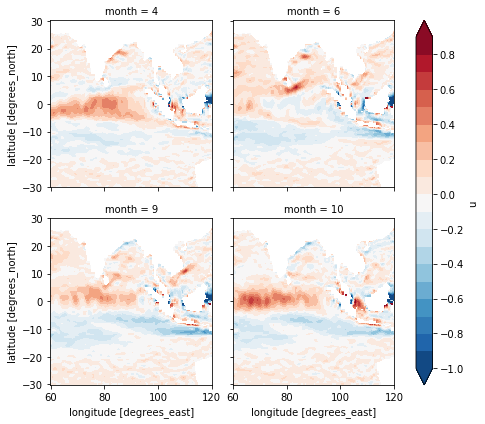

In [37]:
ds_mean.sel(latitude=slice(30,-30),longitude=slice(60,120),month=[4,6,9,10]).u.plot(col='month',col_wrap=2,levels=np.arange(-1,1,0.1))

In [56]:
ds_en4 = xr.open_dataset('/home/lijo/WORK/oceanCurrValidation/data/en42003-2010.nc',decode_times=False)

In [57]:
ds_en4

<xarray.Dataset>
Dimensions:     (DEPTH: 42, LAT: 173, LON: 360, TMON: 96, bnds: 2)
Coordinates:
  * LON         (LON) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * LAT         (LAT) float32 -83.0 -82.0 -81.0 -80.0 ... 86.0 87.0 88.0 89.0
  * DEPTH       (DEPTH) float32 5.0215898 15.07854 ... 5050.9897 5350.272
  * TMON        (TMON) float64 2.436e+03 2.437e+03 ... 2.53e+03 2.531e+03
Dimensions without coordinates: bnds
Data variables:
    DEPTH_bnds  (DEPTH, bnds) float32 ...
    TEMP        (TMON, DEPTH, LAT, LON) float64 ...
    SAL         (TMON, DEPTH, LAT, LON) float64 ...
Attributes:
    history:      FERRET V7.4 (optimized)  5-Jul-18
    Conventions:  CF-1.6

In [58]:
ds_en4.nbytes/1e9

4.017810764

In [ ]:
ds_temp = ds_en4.sel(LAT=slice(10,12),LON=slice(80,82)).isel(TMON=5).TEMP
ds_sal = ds_en4.sel(LAT=slice(10,12),LON=slice(80,82)).isel(TMON=5).SAL
t = xr.where(ds_temp<1000,ds_temp,np.nan) - 273.15
s = xr.where((ds_sal<1000) & (ds_sal>10),ds_sal,np.nan)

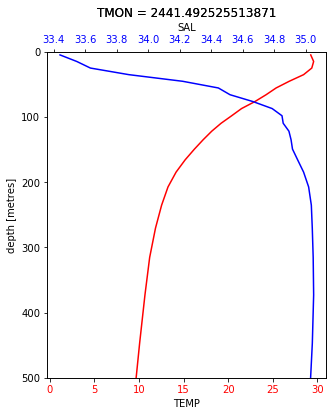

In [109]:
fig,ax = plt.subplots(figsize=(5, 6))
t.mean(dim=['LAT','LON']).plot(ax=ax,y='DEPTH',yincrease=False,ylim=(500,0),color='r')
ax2 = ax.twiny()
s.mean(dim=['LAT','LON']).plot(ax=ax2,y='DEPTH',yincrease=False,ylim=(500,0),color='b')
for ticklabel in ax.get_xticklabels():
    ticklabel.set_color('r')
for ticklabel in ax2.get_xticklabels():
    ticklabel.set_color('b')

## Further resources
* Documentation [page](https://docs.dask.org/en/latest/)
* Dask+Xarray [tutorial](https://github.com/pangeo-data/pangeo-tutorial-sea-2018/tree/master/notebooks)
* Dask [tutorial](https://github.com/dask/dask-tutorial)
* [Example](https://pangeo.io/use_cases/physical-oceanography/sea-surface-height.html) of cloud computing using dask
* Follow Matthew Rocklin's [blog](http://matthewrocklin.com/blog/)